# English to Hausa Translation Model with RNNs and Attention

### This notebook demonstrates the development of an English to Hausa translation model using Recurrent Neural Networks (RNNs) with an attention mechanism. We'll process the provided dataset, build, train, and evaluate the model.

## Import Libraries

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Dropout, Concatenate, Attention
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

print("TensorFlow Version:", tf.__version__)


TensorFlow Version: 2.15.0


## Load and Inspect Dataset

In [80]:
# Load the data
data = pd.read_csv('data/parallel-hausa-tweets.csv')

# Display the first few rows
data.head()


,CleanedMainT,CleanedReplyT,Hausa2EngMainT,Hausa2EngReplyT
0,Jurgen Klopp ya lashe kyautar Fifa ta gwarzon ...,Abunda ya faru tun last week,Jurgen Klopp has won the Fifa World Coach of t...,It's been a while since last week
1,Jurgen Klopp ya lashe kyautar Fifa ta gwarzon ...,Ku sai yanzu ku ke sawa news,Jurgen Klopp has won the Fifa World Coach of t...,You are now wearing news
3,Ƴan bindiga sun kashe mutum da ƙona buhunan ma...,Allah ya isa tsakaninmu da duk wanda yake da s...,Gunmen kill man and burn sacks of maize in Kaduna,May Allah reach between us and all those who a...
4,Ƴan bindiga sun kashe mutum da ƙona buhunan ma...,Innalillahi wa innailaihi rajiun. Wannan kasar...,Gunmen kill man and burn sacks of maize in Kaduna,Innalillahi wa innailaihi rajiun. This country...
5,Ƴan bindiga sun kashe mutum da ƙona buhunan ma...,Subhnallah,Gunmen kill man and burn sacks of maize in Kaduna,Subhnallah


In [81]:
# Display column names
print("Columns:", data.columns.tolist())

# Check for missing values
print("\nMissing values:\n", data.isnull().sum())

# Data information
data.info()


Columns: ['CleanedMainT', 'CleanedReplyT', 'Hausa2EngMainT', 'Hausa2EngReplyT']

Missing values:
 CleanedMainT       0
CleanedReplyT      5
Hausa2EngMainT     0
Hausa2EngReplyT    3
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 292 entries, 0 to 104
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   CleanedMainT     292 non-null    object
 1   CleanedReplyT    287 non-null    object
 2   Hausa2EngMainT   292 non-null    object
 3   Hausa2EngReplyT  289 non-null    object
dtypes: object(4)
memory usage: 11.4+ KB


## Data Preparation

## Combine Main Texts and Replies

In [83]:
# Create a new DataFrame with combined texts
main_df = data[['CleanedMainT', 'Hausa2EngMainT']].rename(
    columns={'CleanedMainT': 'hausa', 'Hausa2EngMainT': 'english'}
)
reply_df = data[['CleanedReplyT', 'Hausa2EngReplyT']].rename(
    columns={'CleanedReplyT': 'hausa', 'Hausa2EngReplyT': 'english'}
)

# Concatenate the two DataFrames
combined_df = pd.concat([main_df, reply_df], ignore_index=True)

# Drop rows with missing values
combined_df = combined_df.dropna()

# Display the combined data
combined_df.head()


,hausa,english
0,Jurgen Klopp ya lashe kyautar Fifa ta gwarzon ...,Jurgen Klopp has won the Fifa World Coach of t...
1,Jurgen Klopp ya lashe kyautar Fifa ta gwarzon ...,Jurgen Klopp has won the Fifa World Coach of t...
2,Ƴan bindiga sun kashe mutum da ƙona buhunan ma...,Gunmen kill man and burn sacks of maize in Kaduna
3,Ƴan bindiga sun kashe mutum da ƙona buhunan ma...,Gunmen kill man and burn sacks of maize in Kaduna
4,Ƴan bindiga sun kashe mutum da ƙona buhunan ma...,Gunmen kill man and burn sacks of maize in Kaduna


## Data Cleaning and Preprocessing

## Define Cleaning Function

In [84]:
def clean_text(text):
    # Convert to string and lowercase
    text = str(text).lower()
    # Remove text in square brackets
    text = re.sub(r'\[.*?\]', '', text)
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text


 ## Apply Cleaning Function

In [85]:
# Apply the cleaning function
combined_df['hausa_clean'] = combined_df['hausa'].apply(clean_text)
combined_df['english_clean'] = combined_df['english'].apply(clean_text)

# Remove empty strings
combined_df = combined_df[
    (combined_df['hausa_clean'].str.len() > 0) &
    (combined_df['english_clean'].str.len() > 0)
]

# Display cleaned data
combined_df[['hausa_clean', 'english_clean']].head()


,hausa_clean,english_clean
0,jurgen klopp ya lashe kyautar fifa ta gwarzon ...,jurgen klopp has won the fifa world coach of t...
1,jurgen klopp ya lashe kyautar fifa ta gwarzon ...,jurgen klopp has won the fifa world coach of t...
2,ƴan bindiga sun kashe mutum da ƙona buhunan ma...,gunmen kill man and burn sacks of maize in kaduna
3,ƴan bindiga sun kashe mutum da ƙona buhunan ma...,gunmen kill man and burn sacks of maize in kaduna
4,ƴan bindiga sun kashe mutum da ƙona buhunan ma...,gunmen kill man and burn sacks of maize in kaduna


In [86]:
print(f"Total samples after cleaning: {len(combined_df)}")


Total samples after cleaning: 579


## Tokenization and Sequence Padding

## Prepare Texts and Add Tokens

In [88]:
# Prepare input and target texts
input_texts = combined_df['hausa_clean'].tolist()
target_texts = combined_df['english_clean'].tolist()

# Add start and end tokens to target texts
target_texts = ['<start> ' + text + ' <end>' for text in target_texts]


## Tokenize the Texts

In [89]:
# Tokenizer for input language (Hausa)
input_tokenizer = Tokenizer(filters='', lower=False)
input_tokenizer.fit_on_texts(input_texts)
input_sequences = input_tokenizer.texts_to_sequences(input_texts)
input_word_index = input_tokenizer.word_index
num_encoder_tokens = len(input_word_index) + 1  # +1 for padding token

# Tokenizer for target language (English)
target_tokenizer = Tokenizer(filters='', lower=False)
target_tokenizer.fit_on_texts(target_texts)
target_sequences = target_tokenizer.texts_to_sequences(target_texts)
target_word_index = target_tokenizer.word_index
num_decoder_tokens = len(target_word_index) + 1  # +1 for padding token


## Determine Maximum Sequence Lengths

In [90]:
max_encoder_seq_length = max(len(seq) for seq in input_sequences)
max_decoder_seq_length = max(len(seq) for seq in target_sequences)

print(f"Number of samples: {len(input_texts)}")
print(f"Number of unique input tokens: {num_encoder_tokens}")
print(f"Number of unique output tokens: {num_decoder_tokens}")
print(f"Max sequence length for inputs: {max_encoder_seq_length}")
print(f"Max sequence length for outputs: {max_decoder_seq_length}")


Number of samples: 579
Number of unique input tokens: 1253
Number of unique output tokens: 965
Max sequence length for inputs: 24
Max sequence length for outputs: 28


## Pad the Sequences

In [92]:
# Pad input sequences
encoder_input_data = pad_sequences(
    input_sequences, maxlen=max_encoder_seq_length, padding='post'
)

# Pad target sequences
decoder_input_data = pad_sequences(
    target_sequences, maxlen=max_decoder_seq_length, padding='post'
)


## Create Decoder Target Data

In [93]:
# Prepare decoder target data
decoder_target_data = np.zeros_like(decoder_input_data)
decoder_target_data[:, 0:-1] = decoder_input_data[:, 1:]
decoder_target_data[:, -1] = 0  # Padding token


## Train-Test Split

In [111]:
# Create an array of indices
data_indices = np.arange(len(input_texts))

# Perform the train-test split, including the indices
(
    encoder_input_train, encoder_input_val,
    decoder_input_train, decoder_input_val,
    decoder_target_train, decoder_target_val,
    train_indices, val_indices
) = train_test_split(
    encoder_input_data,
    decoder_input_data,
    decoder_target_data,
    data_indices,
    test_size=0.1,
    random_state=42
)


## Model Building with Attention

# Set Hyperparameters

In [112]:
embedding_dim = 128
lstm_units = 256


## Define Encoder

In [113]:
# Encoder input layer
encoder_inputs = Input(shape=(None,), name='encoder_inputs')

# Encoder embedding layer
encoder_embedding_layer = Embedding(
    input_dim=num_encoder_tokens, output_dim=embedding_dim, name='encoder_embedding'
)
encoder_embedding = encoder_embedding_layer(encoder_inputs)
encoder_embedding = Dropout(0.2)(encoder_embedding)

# Encoder LSTM
encoder_outputs, state_h, state_c = LSTM(
    lstm_units, return_sequences=True, return_state=True, name='encoder_lstm'
)(encoder_embedding)
encoder_states = [state_h, state_c]


## Define Decoder with Attention


In [114]:
# Decoder input layer
decoder_inputs = Input(shape=(None,), name='decoder_inputs')

# Decoder embedding layer
decoder_embedding_layer = Embedding(
    input_dim=num_decoder_tokens, output_dim=embedding_dim, name='decoder_embedding'
)
decoder_embedding = decoder_embedding_layer(decoder_inputs)
decoder_embedding = Dropout(0.2)(decoder_embedding)

# Decoder LSTM
decoder_lstm = LSTM(
    lstm_units, return_sequences=True, return_state=True, name='decoder_lstm'
)
decoder_outputs, _, _ = decoder_lstm(
    decoder_embedding, initial_state=encoder_states
)

# Attention mechanism using Keras Attention layer
attention_layer = Attention(name='attention_layer')
context_vector = attention_layer(
    [decoder_outputs, encoder_outputs]
)  # Query=decoder_outputs, Value=encoder_outputs

# Concatenate context vector and decoder outputs
decoder_combined_context = Concatenate(
    axis=-1, name='concat_layer'
)([context_vector, decoder_outputs])

# Final output layer
decoder_dense = Dense(
    num_decoder_tokens, activation='softmax', name='decoder_dense'
)
decoder_outputs = decoder_dense(decoder_combined_context)


## Build and Compile the Model

In [115]:
# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy'
)

# Summary of the model
model.summary()


Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_inputs (InputLayer  [(None, None)]               0         []                            
 )                                                                                                
                                                                                                  
 decoder_inputs (InputLayer  [(None, None)]               0         []                            
 )                                                                                                
                                                                                                  


 encoder_embedding (Embeddi  (None, None, 128)            160384    ['encoder_inputs[0][0]']      
 ng)                                                                                              
                                                                                                  
 decoder_embedding (Embeddi  (None, None, 128)            123520    ['decoder_inputs[0][0]']      
 ng)                                                                                              
                                                                                                  
 dropout_12 (Dropout)        (None, None, 128)            0         ['encoder_embedding[0][0]']   
                                                                                                  
 dropout_13 (Dropout)        (None, None, 128)            0         ['decoder_embedding[0][0]']   
                                                                                                  
 encoder_l

## Model Training

## Prepare Target Data

In [117]:
# Reshape decoder target data to be compatible with sparse_categorical_crossentropy
decoder_target_train = decoder_target_train.reshape(
    *decoder_target_train.shape, 1
)
decoder_target_val = decoder_target_val.reshape(
    *decoder_target_val.shape, 1
)


## Define Early Stopping Callback

In [118]:
early_stopping = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)


## Train the Model

In [119]:
history = model.fit(
    [encoder_input_train, decoder_input_train],
    decoder_target_train,
    batch_size=64,
    epochs=50,
    validation_data=([encoder_input_val, decoder_input_val], decoder_target_val),
    callbacks=[early_stopping]
)


Epoch 1/50
9/9 [==============================] - 5s 209ms/step - loss: 6.3351 - val_loss: 2.3005
Epoch 2/50
9/9 [==============================] - 1s 146ms/step - loss: 2.5749 - val_loss: 2.3240
Epoch 3/50
9/9 [==============================] - 1s 139ms/step - loss: 2.3667 - val_loss: 2.1298
Epoch 4/50
9/9 [==============================] - 1s 139ms/step - loss: 2.2746 - val_loss: 2.0984
Epoch 5/50
9/9 [==============================] - 1s 141ms/step - loss: 2.2150 - val_loss: 2.0388
Epoch 6/50
9/9 [==============================] - 1s 139ms/step - loss: 2.1568 - val_loss: 2.0047
Epoch 7/50
9/9 [==============================] - 1s 139ms/step - loss: 2.1103 - val_loss: 1.9486
Epoch 8/50
9/9 [==============================] - 1s 139ms/step - loss: 2.0336 - val_loss: 1.8786
Epoch 9/50
9/9 [==============================] - 1s 139ms/step - loss: 1.9644 - val_loss: 1.8104
Epoch 10/50
9/9 [==============================] - 1s 139ms/step - loss: 1.8994 - val_loss: 1.7711
Epoch 11/50
9/9 [==

## Plot Training History

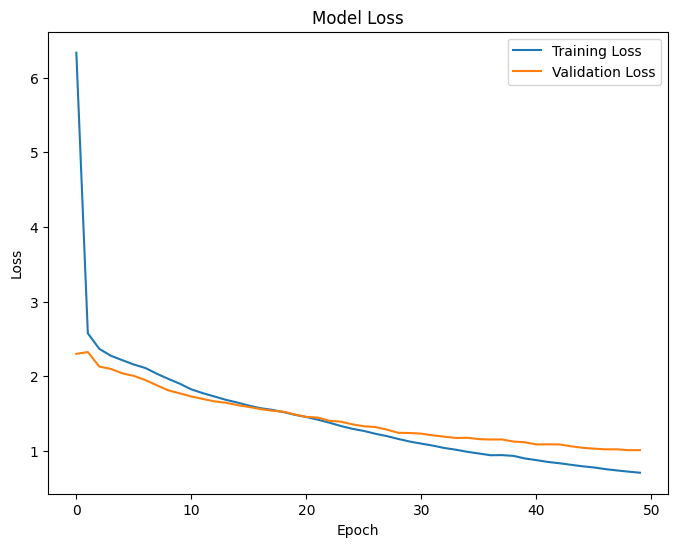

In [120]:
# Plot training & validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


 ## Build Inference Models

## Encoder Model for Inference

In [121]:
encoder_model = Model(encoder_inputs, [encoder_outputs, state_h, state_c])


## Decoder Model for Inference

In [122]:
# Decoder inputs for inference
decoder_state_input_h = Input(
    shape=(lstm_units,), name='decoder_state_input_h'
)
decoder_state_input_c = Input(
    shape=(lstm_units,), name='decoder_state_input_c'
)
decoder_hidden_state_input = Input(
    shape=(None, lstm_units), name='encoder_outputs'
)

# Use the same embedding layer as in training
dec_emb2 = decoder_embedding_layer(decoder_inputs)
dec_emb2 = Dropout(0.2)(dec_emb2)  # Apply dropout if used in training

# Set initial states to states from previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(
    dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c]
)

# Apply attention
context_vector = attention_layer([decoder_outputs2, decoder_hidden_state_input])

# Concatenate context vector and decoder outputs
decoder_combined_context = Concatenate(
    axis=-1, name='concat_layer'
)([context_vector, decoder_outputs2])

# Final output layer
decoder_outputs2 = decoder_dense(decoder_combined_context)

# Final decoder model
decoder_model = Model(
    [
        decoder_inputs,
        decoder_hidden_state_input,
        decoder_state_input_h,
        decoder_state_input_c
    ],
    [decoder_outputs2, state_h2, state_c2]
)


## Create Reverse Word Index

In [123]:
reverse_input_word_index = {
    i: word for word, i in input_word_index.items()
}
reverse_target_word_index = {
    i: word for word, i in target_word_index.items()
}
target_word_index = target_tokenizer.word_index


## Define Decoding Function

In [126]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    encoder_outputs_val, state_h_val, state_c_val = encoder_model.predict(
        input_seq
    )

    # Generate empty target sequence of length 1 with only the start token.
    target_seq = np.array([[target_word_index['<start>']]])

    # Initialize states
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [
                target_seq,
                encoder_outputs_val,
                state_h_val,
                state_c_val
            ]
        )

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = reverse_target_word_index.get(
            sampled_token_index, ''
        )

        # Exit condition: either hit max length or find stop token.
        if (
            sampled_word == '<end>' or
            len(decoded_sentence.split()) >= max_decoder_seq_length
        ):
            stop_condition = True
        else:
            decoded_sentence += ' ' + sampled_word

        # Update the target sequence (length 1).
        target_seq = np.array([[sampled_token_index]])

        # Update states
        state_h_val, state_c_val = h, c

    return decoded_sentence.strip()


## Evaluate the Model

In [128]:
for idx in range(10):
    # Get the actual index in the original data
    val_idx = val_indices[idx]
    
    # Take one sequence from the validation set
    input_seq = encoder_input_val[idx:idx+1]
    decoded_sentence = decode_sequence(input_seq)
    
    # Get the corresponding input sentence and actual translation
    input_sentence = input_texts[val_idx]
    actual_translation = target_texts[val_idx][8:-6]  # Remove <start> and <end>
    
    print(f"Input (Hausa): {input_sentence}")
    print(f"Actual Translation: {actual_translation}")
    print(f"Predicted Translation: {decoded_sentence}")
    print("-" * 50)


1/1 [==============================] - 0s 21ms/step
Input (Hausa): yan bindiga sun sace mai jego a jihar jigawa ƙarin bayani
Actual Translation: gunmen abduct mother in jigawa state
Predicted Translation: gunmen kill man and burn sacks of maize in kaduna
--------------------------------------------------
1/1 [==============================] - 0s 20ms/step
Input (Hausa): hasbunallah
Actual Translation: hasbunallah
Predicted Translation: god bless
--------------------------------------------------
1/1 [==============================] - 0s 20ms/step
Input (Hausa): tsiren ma seyafi kaiwa
Actual Translation: tsiren ma seyafi kai
Predicted Translation: god bless him
--------------------------------------------------
1/1 [==============================] - 0s 20ms/step
Input (Hausa): allah ya jiqansa da rahama
Actual Translation: may allah have mercy on him
Predicted Translation: god bless him
--------------------------------------------------
1/1 [==============================] - 0s 20ms/ste